# Loan Default Prediction

Banks have a huge volume of applicants applying for loans. Some of the applicants do not have credit history or some might have very light credit score. It doesn't mean that lending money to them is highly risky so we should reject all of these applicants. This project uses data about personal loan. Our goal was to develop a model that could step by step explain the results of the model we built and what impact on the likelihood of the case falling into one of the binary categories (loans paid-off and charged). This model predict the 68 % of loan default and would be useful for the banks to make the best decision.

# Obtaining the Data

In [160]:
# importing relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf



from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings('ignore')

import itertools
from collections import Counter


#from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate,cross_val_score

#resample the data
from imblearn.over_sampling import SMOTE,SMOTENC


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix,classification_report,precision_score, recall_score,accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

#Remove warnings
import warnings
warnings.filterwarnings('ignore')




%matplotlib inline
from matplotlib.pylab import rcParams
from matplotlib.ticker import FuncFormatter

In [161]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [162]:
def millions(tick_val,pos):
    """adapted from https://dfrieds.com/data-visualizations/how-format-large-tick-values.html"""
    val = round(tick_val/1000000, 1)
    new_tick_format = '${:.0f}M'.format(val)
    return new_tick_format
form = FuncFormatter(millions)

In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install ipywidgets


Note: you may need to restart the kernel to use updated packages.


Load the data 

In [4]:
original_df = pd.read_csv('/Users/claudiatsai/Documents/Flatiron/Phase_5/data_loan_default_prediction/accepted_2007_to_2018Q4.csv')

Briefly look at the dataset

In [5]:
original_df.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     13.99       123.03     C        C4  ...                            NaN   
1     11.99       820.28     C        C1  ...                            NaN   
2     10.78       432.66     B        B4  ...                            NaN   
3     14.85       829.90     C        C5  ...                            NaN   
4     22.45       289.91     F        F1  ...                            NaN   

  hardship_last_payment_amount disbursement_method  debt_settlement_flag  \
0                          NaN                Cash                     N   
1                          NaN                Cash                     N   
2                          NaN                Cash                     N   
3                          NaN                Cash                     N   
4                          NaN                Cash                     N   

  debt_settlement_flag_date settlement_status settlement_date  \
0                       NaN               NaN             NaN   
1                       NaN               NaN             NaN   
2                       NaN               NaN             NaN   
3                       NaN               NaN             NaN   
4                       NaN               NaN             NaN   

  settlement_amount settlement_percentage settlement_term  
0               NaN                   NaN             NaN  
1               NaN                   NaN             NaN  
2               NaN                   NaN             NaN  
3               NaN                   NaN             NaN  
4               NaN                   NaN             NaN  

[5 rows x 151 columns]

From above, there are 151 features in the dataset. Let's see how many rows in the dataset.

In [6]:
original_df.shape

(2260701, 151)

See how many null values in the dataset.

In [7]:
original_df.isna().sum()

id                             0
member_id                2260701
loan_amnt                     33
funded_amnt                   33
funded_amnt_inv               33
                          ...   
settlement_status        2226455
settlement_date          2226455
settlement_amount        2226455
settlement_percentage    2226455
settlement_term          2226455
Length: 151, dtype: int64

After looked at the null value in the dataset, it looks like some columns contains null values.

In [8]:
((original_df.isna().sum()/len(original_df))*100).sort_values(ascending=False)

member_id                                     100.000000
orig_projected_additional_accrued_interest     99.617331
hardship_end_date                              99.517097
hardship_start_date                            99.517097
hardship_type                                  99.517097
                                                 ...    
policy_code                                     0.001460
revol_bal                                       0.001460
fico_range_high                                 0.001460
fico_range_low                                  0.001460
id                                              0.000000
Length: 151, dtype: float64

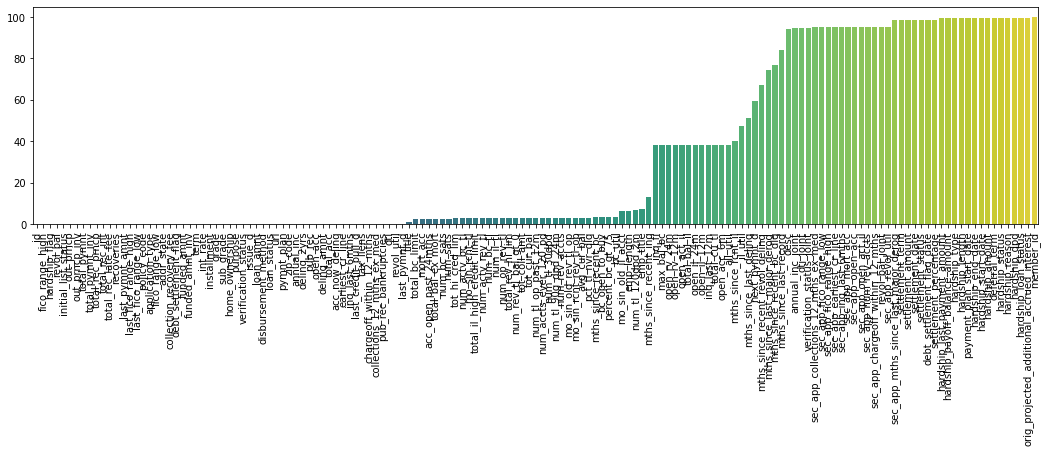

In [9]:
plt.figure(figsize=(18,4)) 

sns.barplot(y=((original_df.isna().sum()/len(original_df))*100).sort_values(), x=((original_df.isna().sum()/len(original_df))*100).sort_values().index, palette='viridis') 
plt.xticks(rotation=90); 

From above barchart, it looks like one third columns in the dataset contains null values.
Keep working on narrowing down columns in the dataset.

In [10]:
features = original_df.columns[((original_df.isna().sum()/len(original_df))*100 < 10)].to_list()
features 

['id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'ch

In [11]:
len(features)

92

Take a closer look at values in each column and decide columns to keep for further analysis.

In [12]:
feat_df =original_df[(features)]

In [13]:
feat_df.iloc[:,0:20].head()

id  loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0  68407277     3600.0       3600.0           3600.0   36 months     13.99   
1  68355089    24700.0      24700.0          24700.0   36 months     11.99   
2  68341763    20000.0      20000.0          20000.0   60 months     10.78   
3  66310712    35000.0      35000.0          35000.0   60 months     14.85   
4  68476807    10400.0      10400.0          10400.0   60 months     22.45   

   installment grade sub_grade                    emp_title emp_length  \
0       123.03     C        C4                      leadman  10+ years   
1       820.28     C        C1                     Engineer  10+ years   
2       432.66     B        B4                 truck driver  10+ years   
3       829.90     C        C5  Information Systems Officer  10+ years   
4       289.91     F        F1          Contract Specialist    3 years   

  home_ownership  annual_inc verification_status   issue_d loan_status  \
0       MORTGAGE     55000.0        Not Verified  Dec-2015  Fully Paid   
1       MORTGAGE     65000.0        Not Verified  Dec-2015  Fully Paid   
2       MORTGAGE     63000.0        Not Verified  Dec-2015  Fully Paid   
3       MORTGAGE    110000.0     Source Verified  Dec-2015     Current   
4       MORTGAGE    104433.0     Source Verified  Dec-2015  Fully Paid   

  pymnt_plan                                                url  \
0          n  https://lendingclub.com/browse/loanDetail.acti...   
1          n  https://lendingclub.com/browse/loanDetail.acti...   
2          n  https://lendingclub.com/browse/loanDetail.acti...   
3          n  https://lendingclub.com/browse/loanDetail.acti...   
4          n  https://lendingclub.com/browse/loanDetail.acti...   

              purpose               title  
0  debt_consolidation  Debt consolidation  
1      small_business            Business  
2    home_improvement                 NaN  
3  debt_consolidation  Debt consolidation  
4      major_purchase      Major purchase

In [14]:
feat_df.purpose.value_counts()

debt_consolidation    1277877
credit_card            516971
home_improvement       150457
other                  139440
major_purchase          50445
medical                 27488
small_business          24689
car                     24013
vacation                15525
moving                  15403
house                   14136
wedding                  2355
renewable_energy         1445
educational               424
Name: purpose, dtype: int64

In [15]:
feat_df.purpose.isna().sum()

33

In [16]:
feat_df.title.unique()

array(['Debt consolidation', 'Business', nan, ..., 'takeitaway',
       'Creditt Card Loan', 'debt reduction/hone updates'], dtype=object)

In [17]:
feat_df.title.isna().sum()

23358

Create a list for the columns I am going to choose

In [18]:
list_1= ['loan_amnt','term','int_rate','sub_grade','emp_title','emp_length','home_ownership','annual_inc',
         'verification_status','loan_status','purpose']

In [19]:
feat_df.iloc[:,21:40].head()

addr_state    dti  delinq_2yrs earliest_cr_line  fico_range_low  \
0         PA   5.91          0.0         Aug-2003           675.0   
1         SD  16.06          1.0         Dec-1999           715.0   
2         IL  10.78          0.0         Aug-2000           695.0   
3         NJ  17.06          0.0         Sep-2008           785.0   
4         PA  25.37          1.0         Jun-1998           695.0   

   fico_range_high  inq_last_6mths  open_acc  pub_rec  revol_bal  revol_util  \
0            679.0             1.0       7.0      0.0     2765.0        29.7   
1            719.0             4.0      22.0      0.0    21470.0        19.2   
2            699.0             0.0       6.0      0.0     7869.0        56.2   
3            789.0             0.0      13.0      0.0     7802.0        11.6   
4            699.0             3.0      12.0      0.0    21929.0        64.5   

   total_acc initial_list_status  out_prncp  out_prncp_inv   total_pymnt  \
0       13.0                   w       0.00           0.00   4421.723917   
1       38.0                   w       0.00           0.00  25679.660000   
2       18.0                   w       0.00           0.00  22705.924294   
3       17.0                   w   15897.65       15897.65  31464.010000   
4       35.0                   w       0.00           0.00  11740.500000   

   total_pymnt_inv  total_rec_prncp  total_rec_int  
0          4421.72          3600.00         821.72  
1         25679.66         24700.00         979.66  
2         22705.92         20000.00        2705.92  
3         31464.01         19102.35       12361.66  
4         11740.50         10400.00        1340.50

In [20]:
feat_df['open_acc'].value_counts()

9.0     195762
10.0    189737
8.0     188717
11.0    175101
7.0     172834
         ...  
77.0         1
93.0         1
90.0         1
79.0         1
97.0         1
Name: open_acc, Length: 91, dtype: int64

Create a second list for the columns I am going to choose

In [21]:
list_2 =['addr_state','fico_range_low','fico_range_high','open_acc','pub_rec','revol_bal','revol_util','total_acc',
        'initial_list_status']

In [22]:
feat_df.iloc[:,41:60].head()

recoveries  collection_recovery_fee last_pymnt_d  last_pymnt_amnt  \
0         0.0                      0.0     Jan-2019           122.67   
1         0.0                      0.0     Jun-2016           926.35   
2         0.0                      0.0     Jun-2017         15813.30   
3         0.0                      0.0     Feb-2019           829.90   
4         0.0                      0.0     Jul-2016         10128.96   

  last_credit_pull_d  last_fico_range_high  last_fico_range_low  \
0           Mar-2019                 564.0                560.0   
1           Mar-2019                 699.0                695.0   
2           Mar-2019                 704.0                700.0   
3           Mar-2019                 679.0                675.0   
4           Mar-2018                 704.0                700.0   

   collections_12_mths_ex_med  policy_code application_type  acc_now_delinq  \
0                         0.0          1.0       Individual             0.0   
1                         0.0          1.0       Individual             0.0   
2                         0.0          1.0        Joint App             0.0   
3                         0.0          1.0       Individual             0.0   
4                         0.0          1.0       Individual             0.0   

   tot_coll_amt  tot_cur_bal  total_rev_hi_lim  acc_open_past_24mths  \
0         722.0     144904.0            9300.0                   4.0   
1           0.0     204396.0          111800.0                   4.0   
2           0.0     189699.0           14000.0                   6.0   
3           0.0     301500.0           67300.0                   2.0   
4           0.0     331730.0           34000.0                  10.0   

   avg_cur_bal  bc_open_to_buy  bc_util  chargeoff_within_12_mths  
0      20701.0          1506.0     37.2                       0.0  
1       9733.0         57830.0     27.1                       0.0  
2      31617.0          2737.0     55.9                       0.0  
3      23192.0         54962.0     12.1                       0.0  
4      27644.0          4567.0     77.5                       0.0

In [23]:
feat_df['chargeoff_within_12_mths'].value_counts()

0.0     2243339
1.0       15765
2.0        1115
3.0         186
4.0          68
5.0          22
6.0          12
7.0           8
9.0           5
8.0           2
10.0          1
Name: chargeoff_within_12_mths, dtype: int64

Create a third list for the columns I am going to choose from above

In [24]:
list_3=['application_type','tot_cur_bal']

In [25]:
feat_df.iloc[:,61:80].head()

mo_sin_old_il_acct  mo_sin_old_rev_tl_op  mo_sin_rcnt_rev_tl_op  \
0               148.0                 128.0                    3.0   
1               113.0                 192.0                    2.0   
2               125.0                 184.0                   14.0   
3                36.0                  87.0                    2.0   
4               128.0                 210.0                    4.0   

   mo_sin_rcnt_tl  mort_acc  mths_since_recent_bc  num_accts_ever_120_pd  \
0             3.0       1.0                   4.0                    2.0   
1             2.0       4.0                   2.0                    0.0   
2            14.0       5.0                 101.0                    0.0   
3             2.0       1.0                   2.0                    0.0   
4             4.0       6.0                   4.0                    0.0   

   num_actv_bc_tl  num_actv_rev_tl  num_bc_sats  num_bc_tl  num_il_tl  \
0             2.0              4.0          2.0        5.0        3.0   
1             5.0              5.0         13.0       17.0        6.0   
2             2.0              3.0          2.0        4.0        6.0   
3             4.0              5.0          8.0       10.0        2.0   
4             4.0              6.0          5.0        9.0       10.0   

   num_op_rev_tl  num_rev_accts  num_rev_tl_bal_gt_0  num_sats  \
0            4.0            9.0                  4.0       7.0   
1           20.0           27.0                  5.0      22.0   
2            4.0            7.0                  3.0       6.0   
3           10.0           13.0                  5.0      13.0   
4            7.0           19.0                  6.0      12.0   

   num_tl_120dpd_2m  num_tl_30dpd  num_tl_90g_dpd_24m  
0               0.0           0.0                 0.0  
1               0.0           0.0                 0.0  
2               0.0           0.0                 0.0  
3               0.0           0.0                 0.0  
4               0.0           0.0                 0.0

In [26]:
feat_df.mort_acc.value_counts()

0.0     929606
1.0     393270
2.0     325903
3.0     231066
4.0     150002
5.0      86666
6.0      46804
7.0      23419
8.0      11450
9.0       5742
10.0      2913
11.0      1541
12.0       815
13.0       466
14.0       311
15.0       178
16.0       125
17.0        87
18.0        64
19.0        37
20.0        34
22.0        20
23.0        20
24.0        19
21.0        17
25.0        12
27.0         8
26.0         6
28.0         6
29.0         4
31.0         4
32.0         3
30.0         3
34.0         3
37.0         2
45.0         1
33.0         1
87.0         1
36.0         1
51.0         1
35.0         1
94.0         1
41.0         1
46.0         1
52.0         1
47.0         1
61.0         1
Name: mort_acc, dtype: int64

In [27]:
feat_df.num_actv_bc_tl.value_counts()

3.0     458887
2.0     442726
4.0     357154
1.0     256818
5.0     240636
6.0     152238
7.0      91653
8.0      55107
0.0      50061
9.0      33163
10.0     19926
11.0     12264
12.0      7382
13.0      4538
14.0      2736
15.0      1798
16.0      1078
17.0       752
18.0       495
19.0       325
20.0       185
21.0       134
22.0        97
23.0        66
24.0        60
25.0        27
26.0        23
27.0        14
29.0        12
30.0         9
28.0         8
32.0         5
33.0         4
36.0         2
48.0         2
35.0         1
45.0         1
31.0         1
50.0         1
46.0         1
47.0         1
37.0         1
Name: num_actv_bc_tl, dtype: int64

Create a list from above columns

In [28]:
list_4=['mort_acc','num_actv_bc_tl']

In [29]:
feat_df.iloc[:,81:92].head()

pct_tl_nvr_dlq  percent_bc_gt_75  pub_rec_bankruptcies  tax_liens  \
0            76.9               0.0                   0.0        0.0   
1            97.4               7.7                   0.0        0.0   
2           100.0              50.0                   0.0        0.0   
3           100.0               0.0                   0.0        0.0   
4            96.6              60.0                   0.0        0.0   

   tot_hi_cred_lim  total_bal_ex_mort  total_bc_limit  \
0         178050.0             7746.0          2400.0   
1         314017.0            39475.0         79300.0   
2         218418.0            18696.0          6200.0   
3         381215.0            52226.0         62500.0   
4         439570.0            95768.0         20300.0   

   total_il_high_credit_limit hardship_flag disbursement_method  \
0                     13734.0             N                Cash   
1                     24667.0             N                Cash   
2                     14877.0             N                Cash   
3                     18000.0             N                Cash   
4                     88097.0             N                Cash   

  debt_settlement_flag  
0                    N  
1                    N  
2                    N  
3                    N  
4                    N

In [30]:
feat_df.hardship_flag.value_counts()

N    2259836
Y        832
Name: hardship_flag, dtype: int64

In [31]:
feat_df.pub_rec_bankruptcies.value_counts()

0.0     1987383
1.0      258444
2.0       10518
3.0        2131
4.0         541
5.0         188
6.0          60
7.0          23
8.0          10
9.0           3
11.0          1
12.0          1
Name: pub_rec_bankruptcies, dtype: int64

Create fourth list and from above columns

In [32]:
list_5= ['pub_rec_bankruptcies']

Combine the 5 lists of features

In [33]:
cols=list_1+list_2+list_3+list_4+list_5

In [34]:
cols

['loan_amnt',
 'term',
 'int_rate',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'loan_status',
 'purpose',
 'addr_state',
 'fico_range_low',
 'fico_range_high',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'application_type',
 'tot_cur_bal',
 'mort_acc',
 'num_actv_bc_tl',
 'pub_rec_bankruptcies']

The size of the dataset I downloaded from Kaggle is 1.3GB. 
In order to run the cells more quickly, use above columns and created a new cvs file,"selected_features".

In [35]:
cols=[
    'term',
 'sub_grade',
 'home_ownership',
 'verification_status', 
      'application_type',
      'purpose',
      'addr_state',
      'pub_rec_bankruptcies',
       'pub_rec',
    'loan_status',
 'loan_amnt',
 'int_rate',
 'emp_title',
 'emp_length',
 'annual_inc',
 'fico_range_low',
 'fico_range_high',
 'open_acc',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'tot_cur_bal',
 'mort_acc',
 'num_actv_bc_tl',

 ]
cols

['term',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'application_type',
 'purpose',
 'addr_state',
 'pub_rec_bankruptcies',
 'pub_rec',
 'loan_status',
 'loan_amnt',
 'int_rate',
 'emp_title',
 'emp_length',
 'annual_inc',
 'fico_range_low',
 'fico_range_high',
 'open_acc',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'tot_cur_bal',
 'mort_acc',
 'num_actv_bc_tl']

In [36]:
filename = r"/Users/claudiatsai/Documents/Flatiron/Phase_5/data_loan_default_prediction/accepted_2007_to_2018Q4.csv"


pd.read_csv(filename, usecols=cols).to_csv(r'/Users/claudiatsai/Documents/Flatiron/Phase_5/data_loan_default_prediction/selected_features.csv', index=False)

In [37]:
loan=pd.read_csv('/Users/claudiatsai/Documents/Flatiron/Phase_5/data_loan_default_prediction/selected_features.csv')

In [38]:
loan.head()

loan_amnt        term  int_rate sub_grade                    emp_title  \
0     3600.0   36 months     13.99        C4                      leadman   
1    24700.0   36 months     11.99        C1                     Engineer   
2    20000.0   60 months     10.78        B4                 truck driver   
3    35000.0   60 months     14.85        C5  Information Systems Officer   
4    10400.0   60 months     22.45        F1          Contract Specialist   

  emp_length home_ownership  annual_inc verification_status loan_status  ...  \
0  10+ years       MORTGAGE     55000.0        Not Verified  Fully Paid  ...   
1  10+ years       MORTGAGE     65000.0        Not Verified  Fully Paid  ...   
2  10+ years       MORTGAGE     63000.0        Not Verified  Fully Paid  ...   
3  10+ years       MORTGAGE    110000.0     Source Verified     Current  ...   
4    3 years       MORTGAGE    104433.0     Source Verified  Fully Paid  ...   

  pub_rec revol_bal  revol_util  total_acc  initial_list_status  \
0     0.0    2765.0        29.7       13.0                    w   
1     0.0   21470.0        19.2       38.0                    w   
2     0.0    7869.0        56.2       18.0                    w   
3     0.0    7802.0        11.6       17.0                    w   
4     0.0   21929.0        64.5       35.0                    w   

   application_type  tot_cur_bal  mort_acc  num_actv_bc_tl  \
0        Individual     144904.0       1.0             2.0   
1        Individual     204396.0       4.0             5.0   
2         Joint App     189699.0       5.0             2.0   
3        Individual     301500.0       1.0             4.0   
4        Individual     331730.0       6.0             4.0   

  pub_rec_bankruptcies  
0                  0.0  
1                  0.0  
2                  0.0  
3                  0.0  
4                  0.0  

[5 rows x 25 columns]

# Scrubbing and Cleaning Data

In [40]:
loan.dtypes

loan_amnt               float64
term                     object
int_rate                float64
sub_grade                object
emp_title                object
emp_length               object
home_ownership           object
annual_inc              float64
verification_status      object
loan_status              object
purpose                  object
addr_state               object
fico_range_low          float64
fico_range_high         float64
open_acc                float64
pub_rec                 float64
revol_bal               float64
revol_util              float64
total_acc               float64
initial_list_status      object
application_type         object
tot_cur_bal             float64
mort_acc                float64
num_actv_bc_tl          float64
pub_rec_bankruptcies    float64
dtype: object

### loan_status 

Loan_status is the dependent variable in the dataset.

In [41]:
loan.loan_status.value_counts(normalize=True)

Fully Paid                                             0.476298
Current                                                0.388521
Charged Off                                            0.118796
Late (31-120 days)                                     0.009496
In Grace Period                                        0.003732
Late (16-30 days)                                      0.001924
Does not meet the credit policy. Status:Fully Paid     0.000879
Does not meet the credit policy. Status:Charged Off    0.000337
Default                                                0.000018
Name: loan_status, dtype: float64

Focus on "Fully Paid" and "Charged Off" in loan_status.

In [42]:
#loan = loan[(loan['loan_status'] == 'Fully Paid') | (loan['loan_status'] == 'Charged Off')]

In [43]:
loan_list=['Charged Off', 'Fully Paid']
loan= loan.loc[loan['loan_status'].isin(loan_list)]

In [44]:
loan.loan_status.value_counts()

Fully Paid     1076751
Charged Off     268559
Name: loan_status, dtype: int64

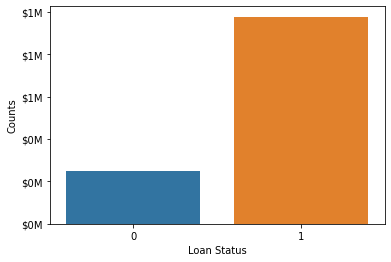

In [163]:
loan_status = loan['loan_status'].value_counts()
ax = sns.barplot(x = loan_status.index, y = loan_status.values)
ax.set_ylabel('Counts')
ax.set_xlabel('Loan Status')
ax.yaxis.set_major_formatter(form)

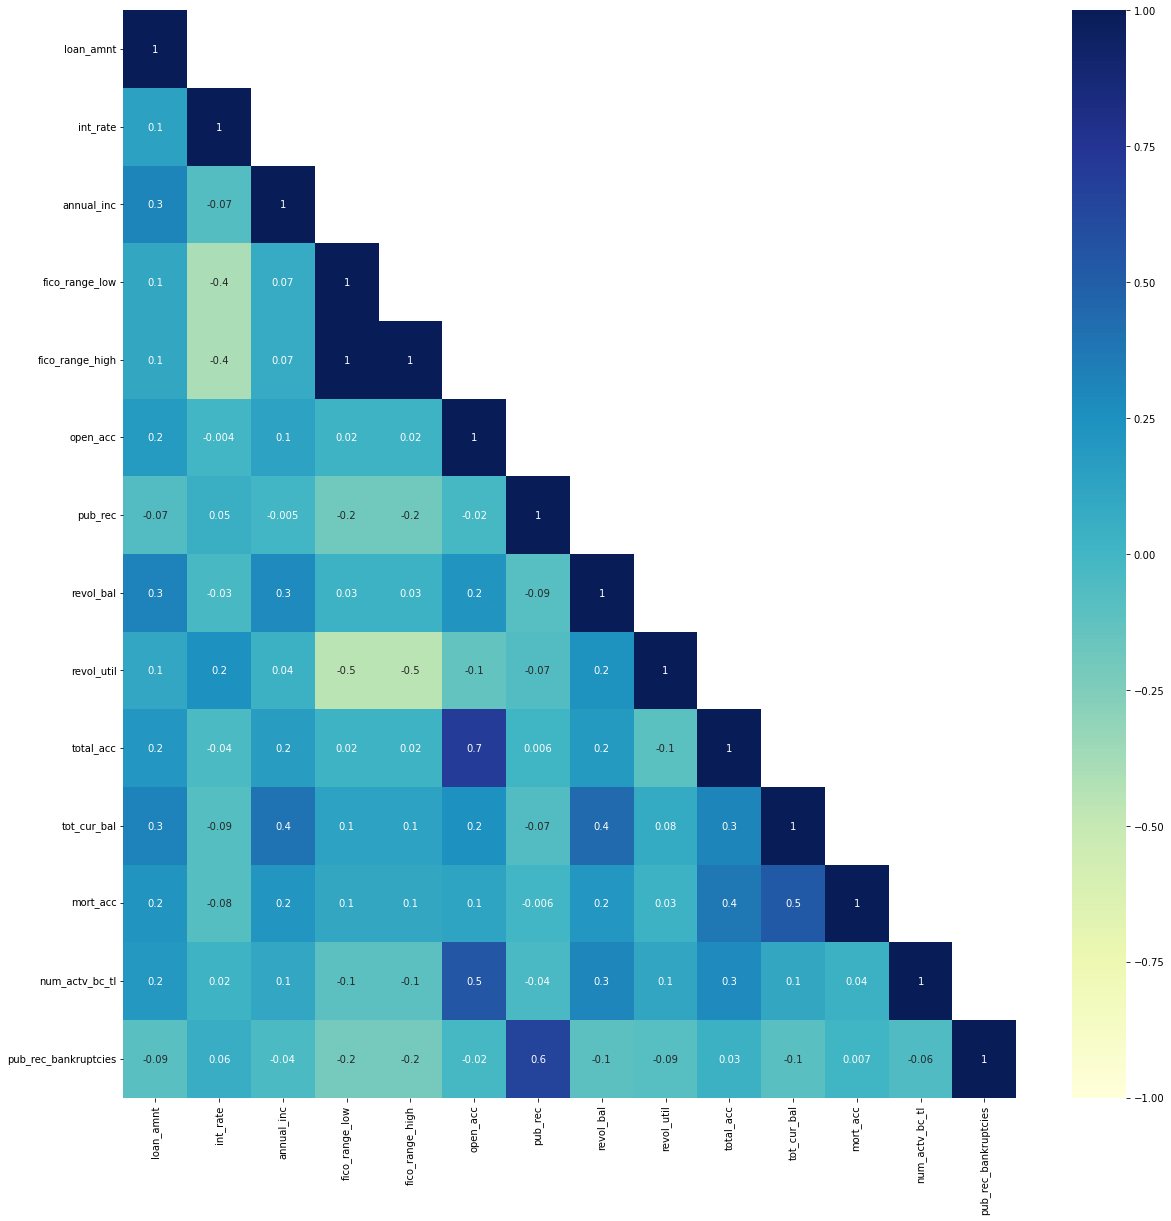

In [46]:
'''showed the lower triangular heatmap
https://datavizpyr.com/how-to-make-lower-triangular-heatmap-with-python/
'''
corr = loan.corr()
corr_tri = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(data = corr_tri, center = 0, cmap = "YlGnBu", annot = True, fmt='.1g',vmin=-1);

Check the null values in each variable

In [47]:
loan.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
sub_grade                   0
emp_title               85785
emp_length              78511
home_ownership              0
annual_inc                  0
verification_status         0
loan_status                 0
purpose                     0
addr_state                  0
fico_range_low              0
fico_range_high             0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                857
total_acc                   0
initial_list_status         0
application_type            0
tot_cur_bal             67527
mort_acc                47281
num_actv_bc_tl          67527
pub_rec_bankruptcies      697
dtype: int64

In [48]:
null_data = ((loan.isna().sum()/len(loan))*100)[((loan.isna().sum()/len(loan))*100) > 0]
null_data

emp_title               6.376597
emp_length              5.835904
revol_util              0.063703
tot_cur_bal             5.019438
mort_acc                3.514506
num_actv_bc_tl          5.019438
pub_rec_bankruptcies    0.051810
dtype: float64

### emp_title

In [49]:
loan.emp_title.describe()

count     1259525
unique     378353
top       Teacher
freq        21268
Name: emp_title, dtype: object

The unique values of emp_titles are 378353 which is way more too large to put into categories. 
Drop this column.

In [50]:
loan = loan.drop('emp_title', axis=1)

### emp_length

In [51]:
loan.emp_length.value_counts(normalize=True)

10+ years    0.349068
2 years      0.096103
< 1 year     0.085302
3 years      0.084936
1 year       0.069856
5 years      0.066430
4 years      0.063590
6 years      0.049521
8 years      0.047917
7 years      0.047067
9 years      0.040209
Name: emp_length, dtype: float64

In [52]:
emp_length_order = [ '< 1 year', '1 year', '2 years', '3 years', '4 years',
                    '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']

<AxesSubplot:xlabel='emp_length', ylabel='count'>

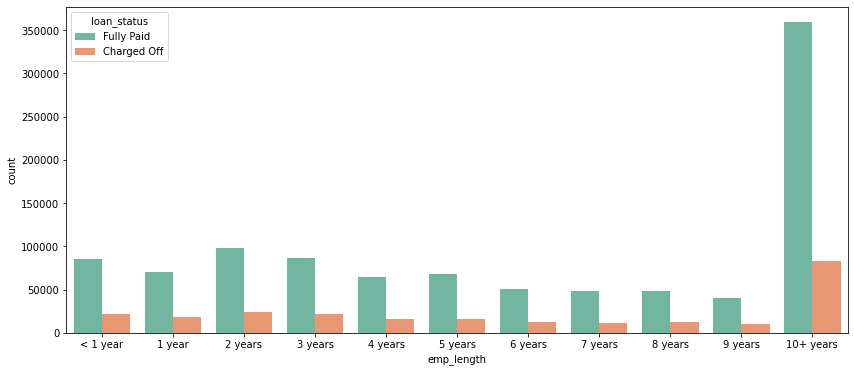

In [53]:
plt.figure(figsize=(14,6))
sns.countplot(x='emp_length',data=loan,order=emp_length_order,hue='loan_status', palette='Set2')

In [54]:
for order in emp_length_order:
    print(f"{order}:")
    print(f"{loan[loan.emp_length == order].loan_status.value_counts(normalize=True)}")
    

< 1 year:
Fully Paid     0.794727
Charged Off    0.205273
Name: loan_status, dtype: float64
1 year:
Fully Paid     0.794359
Charged Off    0.205641
Name: loan_status, dtype: float64
2 years:
Fully Paid     0.801927
Charged Off    0.198073
Name: loan_status, dtype: float64
3 years:
Fully Paid     0.80031
Charged Off    0.19969
Name: loan_status, dtype: float64
4 years:
Fully Paid     0.802622
Charged Off    0.197378
Name: loan_status, dtype: float64
5 years:
Fully Paid     0.80399
Charged Off    0.19601
Name: loan_status, dtype: float64
6 years:
Fully Paid     0.806481
Charged Off    0.193519
Name: loan_status, dtype: float64
7 years:
Fully Paid     0.805112
Charged Off    0.194888
Name: loan_status, dtype: float64
8 years:
Fully Paid     0.800662
Charged Off    0.199338
Name: loan_status, dtype: float64
9 years:
Fully Paid     0.800989
Charged Off    0.199011
Name: loan_status, dtype: float64
10+ years:
Fully Paid     0.812173
Charged Off    0.187827
Name: loan_status, dtype: float64


From above data, charged off rate is 19%-20% in each employee lengths. So emp_length will be dropped as well.

In [55]:
loan = loan.drop('emp_length',axis=1)

### revol_util

revol_util: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

Feature "revol_util" has 0.06% null values in the dataset. Use the mean value to fill the null value.

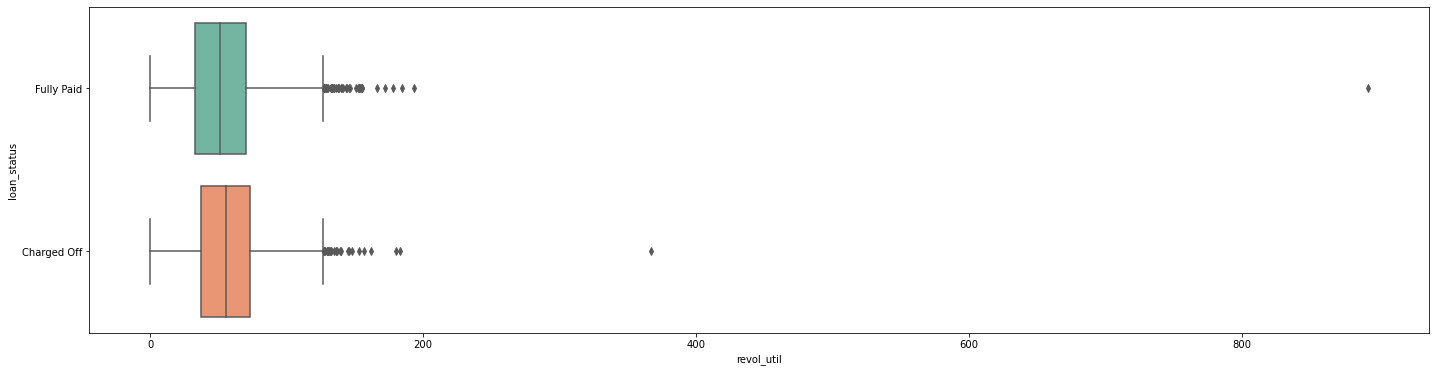

In [56]:
plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='revol_util', y='loan_status', palette='Set2');

In [57]:
loan.revol_util = loan.revol_util.fillna(loan.revol_util.mean())

In [58]:
loan.revol_util.isna().sum()

0

In [59]:
loan.groupby('loan_status')['revol_util'].describe()

count       mean        std  min   25%   50%   75%    max
loan_status                                                               
Charged Off   268559.0  54.756457  23.858104  0.0  37.4  55.5  73.1  366.6
Fully Paid   1076751.0  51.075134  24.619085  0.0  32.5  51.3  70.0  892.3

In [60]:
loan.shape

(1345310, 23)

From above boxplot, outliers are observed.

In [61]:
loan = loan[loan['revol_util'] < 150]

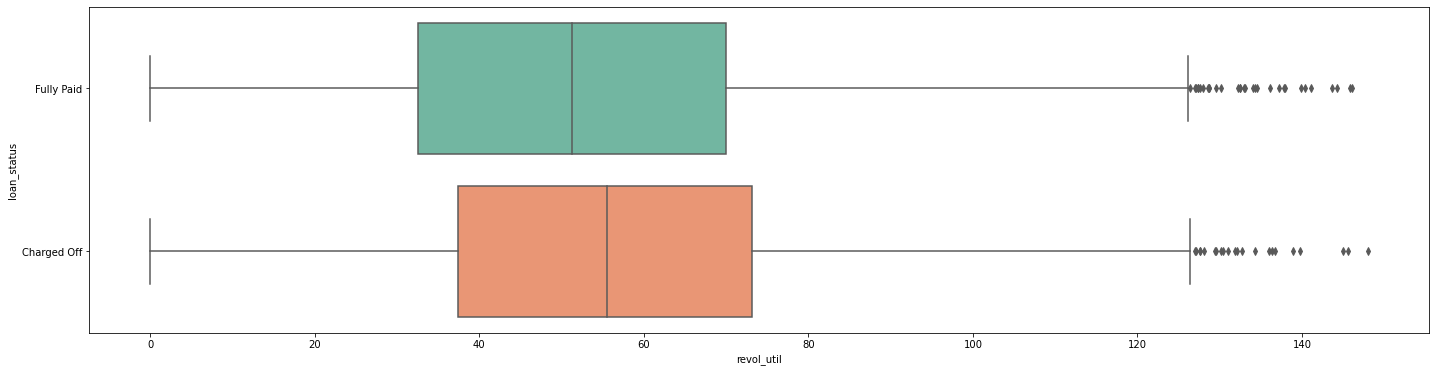

In [62]:
plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='revol_util', y='loan_status', palette='Set2');

### revol_bal 

In [63]:
loan.groupby('loan_status')['revol_bal'].describe()

count          mean           std  min     25%      50%  \
loan_status                                                                
Charged Off   268553.0  15353.432246  18954.234102  0.0  5990.0  11072.0   
Fully Paid   1076737.0  16471.013187  23086.414865  0.0  5931.0  11150.0   

                 75%        max  
loan_status                      
Charged Off  19101.0  1746716.0  
Fully Paid   19925.0  2904836.0

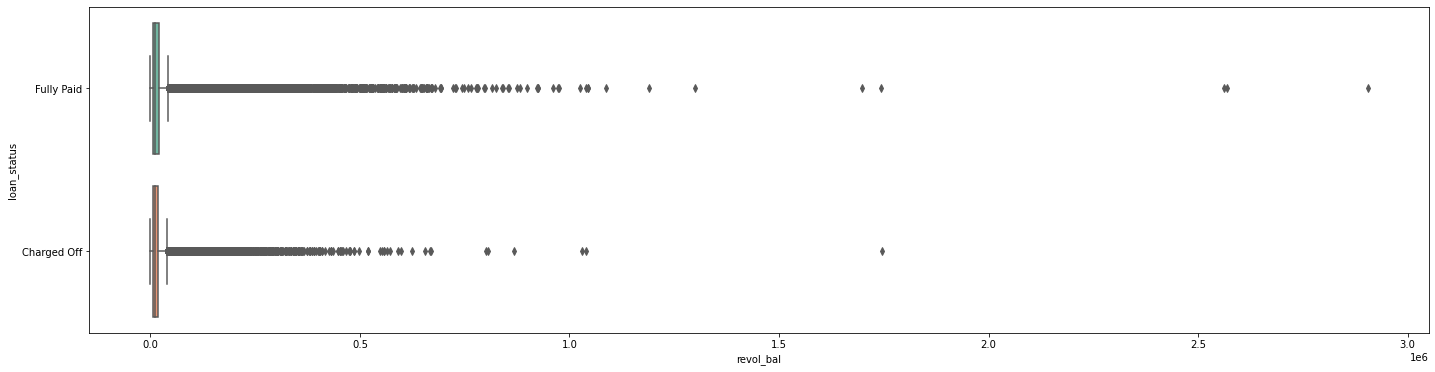

In [64]:

plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='revol_bal', y='loan_status', palette='Set2');


From above boxplot, outliers are observed. Keep the revolving balance less than $100,000.

In [65]:
loan = loan[loan['revol_bal'] < 100000]

In [66]:
loan.groupby('loan_status')['revol_bal'].describe()

count          mean           std  min     25%      50%  \
loan_status                                                                
Charged Off   266943.0  14427.093297  12618.010412  0.0  5962.0  11001.0   
Fully Paid   1066241.0  14919.489590  13529.347531  0.0  5887.0  11028.0   

                 75%      max  
loan_status                    
Charged Off  18890.5  99991.0  
Fully Paid   19544.0  99992.0

### mort_acc

#Feature "mort_acc" has 3.51% null values in the dataset. 

In [67]:
loan.mort_acc.isna().sum()

47037

In [68]:
loan.groupby('loan_status')['mort_acc'].describe()

count      mean       std  min  25%  50%  75%   max
loan_status                                                         
Charged Off   260082.0  1.359894  1.815383  0.0  0.0  1.0  2.0  29.0
Fully Paid   1026065.0  1.728362  2.021337  0.0  0.0  1.0  3.0  51.0

It looks like there are some outliers in the "mort_acc".

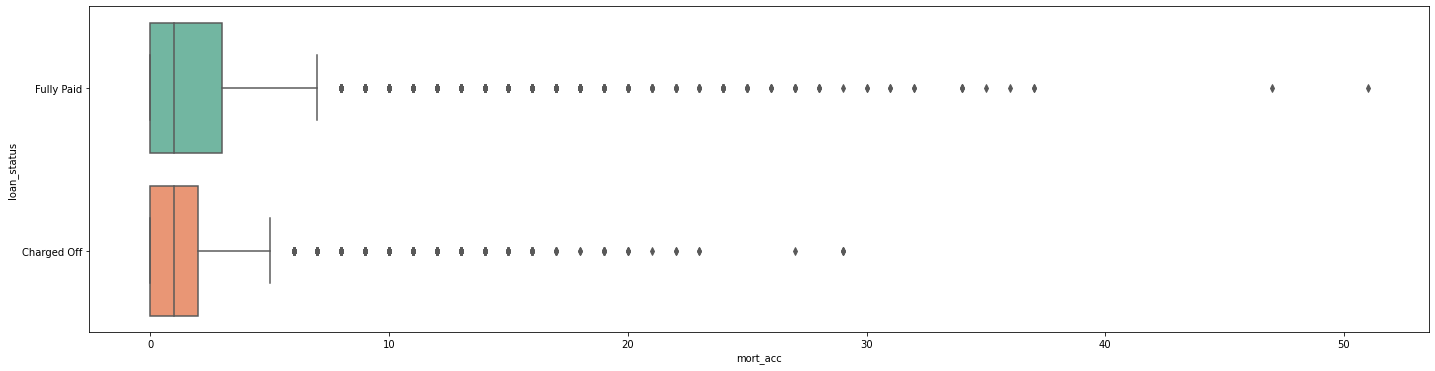

In [69]:
plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='mort_acc', y='loan_status', palette='Set2');

In [70]:
loan = loan[loan['mort_acc'] < 10]

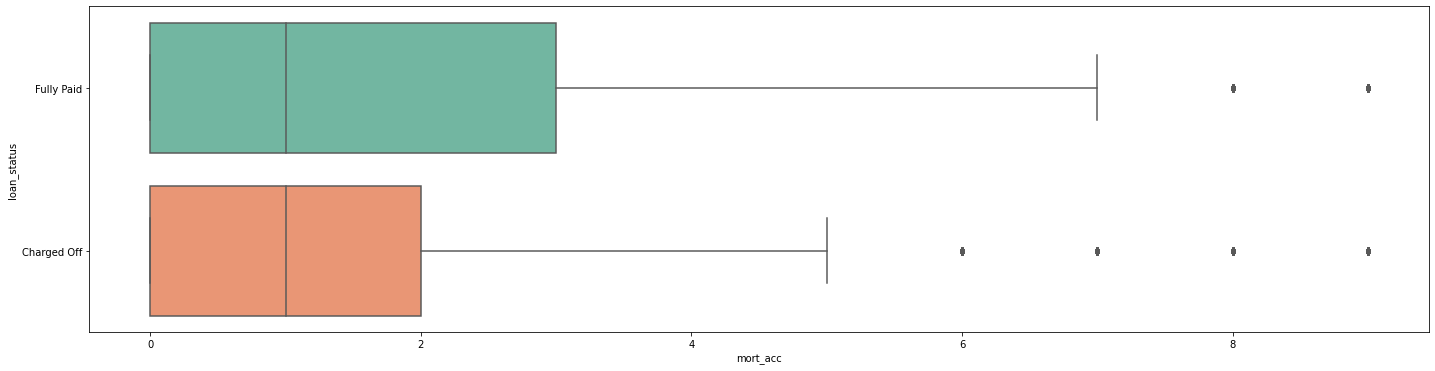

In [71]:
plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='mort_acc', y='loan_status', palette='Set2');

In [72]:
loan.mort_acc.value_counts()

0.0    523154
1.0    224572
2.0    186529
3.0    137029
4.0     93239
5.0     56405
6.0     31791
7.0     16394
8.0      8097
9.0      4131
Name: mort_acc, dtype: int64

In [73]:
loan.mort_acc.isna().sum()

0

In [74]:
loan.shape

(1281341, 23)

### num_actv_bc_tl

#Feature "num_actv_ba_tl" has 5.01% null values in the dataset.

In [75]:
loan.groupby('loan_status')['num_actv_bc_tl'].describe()

count      mean       std  min  25%  50%  75%   max
loan_status                                                         
Charged Off   256082.0  3.816211  2.352194  0.0  2.0  3.0  5.0  30.0
Fully Paid   1005182.0  3.577841  2.194206  0.0  2.0  3.0  5.0  33.0

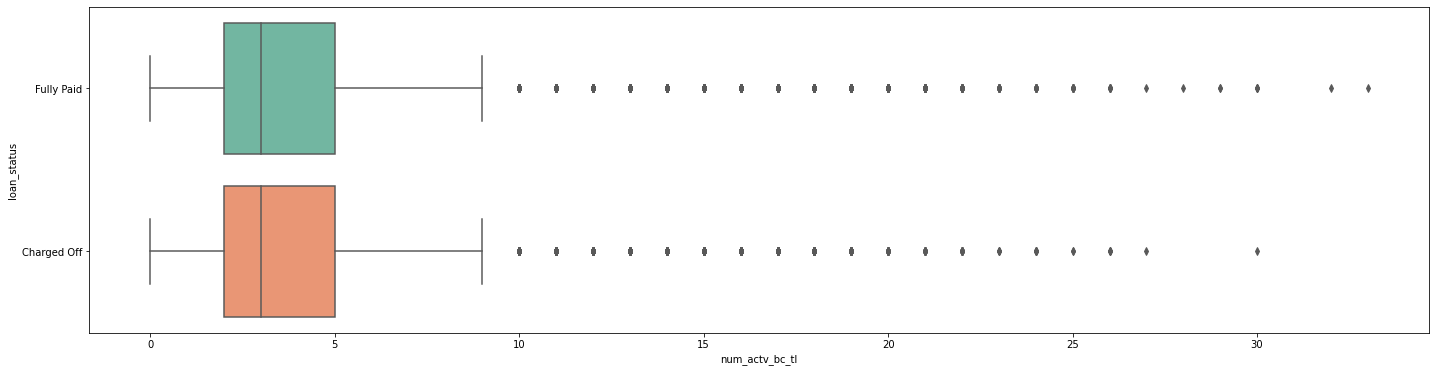

In [76]:
plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='num_actv_bc_tl', y='loan_status', palette='Set2');

In [77]:
loan.num_actv_bc_tl.value_counts()

3.0     271162
2.0     258563
4.0     209855
1.0     145277
5.0     139720
6.0      86523
7.0      50711
8.0      29670
0.0      27100
9.0      17418
10.0     10210
11.0      6043
12.0      3565
13.0      2120
14.0      1194
15.0       793
16.0       452
17.0       337
18.0       191
19.0       133
20.0        69
21.0        45
22.0        35
23.0        21
24.0        21
25.0        13
26.0        11
30.0         5
27.0         2
29.0         2
32.0         1
33.0         1
28.0         1
Name: num_actv_bc_tl, dtype: int64

In [78]:
loan = loan[loan['num_actv_bc_tl'] < 10]

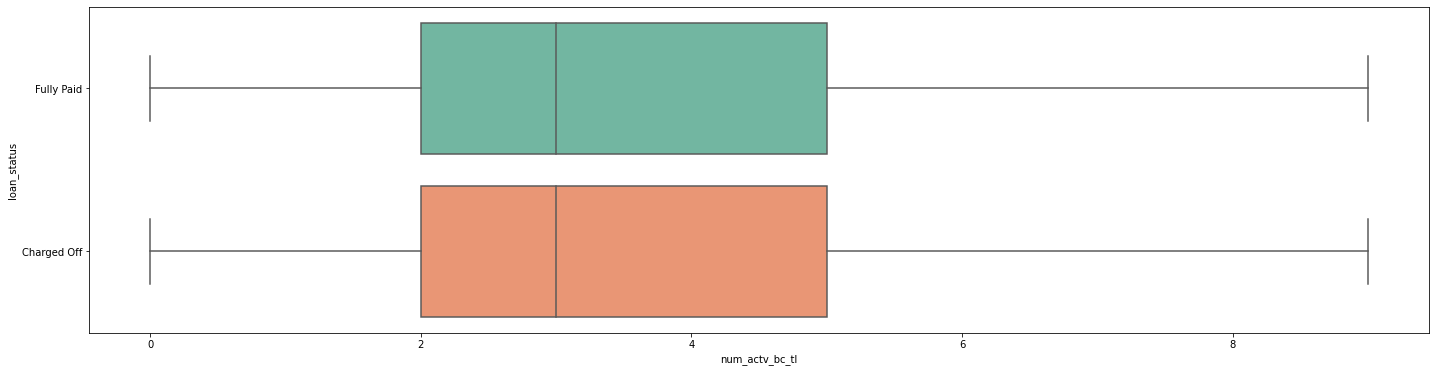

In [79]:
plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='num_actv_bc_tl', y='loan_status', palette='Set2');

In [80]:
loan.corr()['num_actv_bc_tl'].sort_values()[:-1]

fico_range_high        -0.115400
fico_range_low         -0.115399
pub_rec_bankruptcies   -0.053122
pub_rec                -0.029818
int_rate                0.022820
mort_acc                0.027731
tot_cur_bal             0.081427
annual_inc              0.087219
revol_util              0.122930
loan_amnt               0.185325
total_acc               0.237218
revol_bal               0.406559
open_acc                0.473297
Name: num_actv_bc_tl, dtype: float64

In [81]:
loan.shape

(1235999, 23)

### pub_rec_bankruptcies

Number of public record bankruptcies.

In [82]:
loan.pub_rec_bankruptcies.isna().sum()

0

In [83]:
loan.groupby('loan_status')['pub_rec_bankruptcies'].describe()

count      mean       std  min  25%  50%  75%   max
loan_status                                                        
Charged Off  249420.0  0.160428  0.412259  0.0  0.0  0.0  0.0  11.0
Fully Paid   986579.0  0.137761  0.381250  0.0  0.0  0.0  0.0  12.0

In [84]:
loan.pub_rec_bankruptcies.value_counts()

0.0     1072993
1.0      153183
2.0        7661
3.0        1560
4.0         393
5.0         137
6.0          44
7.0          14
8.0           9
9.0           3
11.0          1
12.0          1
Name: pub_rec_bankruptcies, dtype: int64

In [85]:
loan['pub_rec_bankruptcies']= loan['pub_rec_bankruptcies'].apply(lambda x:0 if x==0 else 1 )
                                                                  
loan['pub_rec_bankruptcies'].value_counts()

0    1072993
1     163006
Name: pub_rec_bankruptcies, dtype: int64

### pub_rec

Number of derogatory public records.

In [86]:
loan.groupby('loan_status')['pub_rec'].describe()

count      mean       std  min  25%  50%  75%   max
loan_status                                                        
Charged Off  249420.0  0.256984  0.670583  0.0  0.0  0.0  0.0  86.0
Fully Paid   986579.0  0.219314  0.599310  0.0  0.0  0.0  0.0  63.0

In [87]:
loan.pub_rec.value_counts()

0.0     1015437
1.0      184481
2.0       23788
3.0        7191
4.0        2555
5.0        1232
6.0         613
7.0         270
8.0         156
9.0          79
10.0         56
11.0         40
12.0         27
13.0         17
15.0          9
21.0          6
19.0          5
16.0          5
18.0          5
14.0          4
17.0          3
24.0          2
22.0          2
20.0          2
28.0          2
86.0          1
63.0          1
25.0          1
54.0          1
34.0          1
37.0          1
40.0          1
46.0          1
47.0          1
49.0          1
23.0          1
61.0          1
Name: pub_rec, dtype: int64

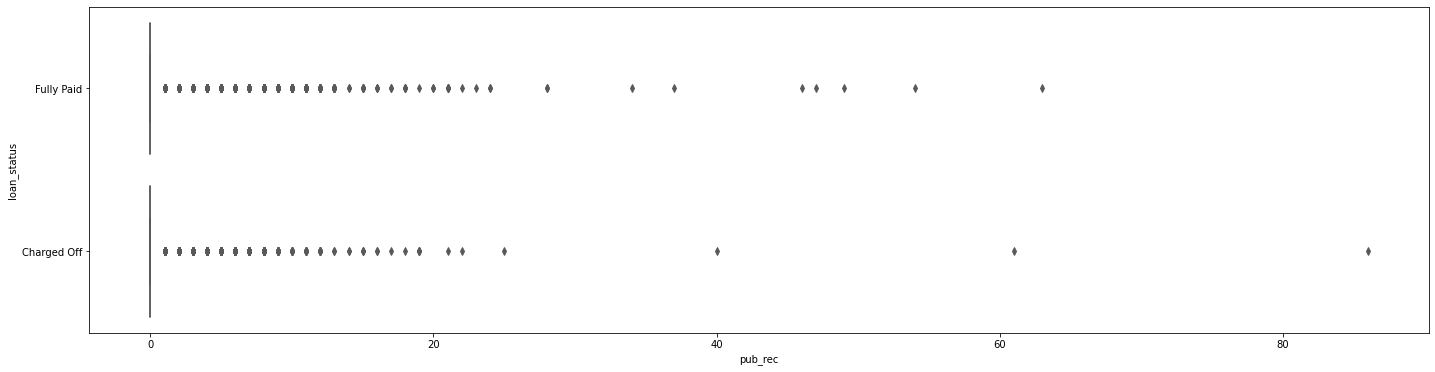

In [88]:
plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='pub_rec', y='loan_status', palette='Set2');

In [89]:
loan['pub_rec']= loan['pub_rec'].apply(lambda x:0 if x==0 else 1 )
                                                  
loan['pub_rec'].value_counts()

0    1015437
1     220562
Name: pub_rec, dtype: int64

### loan_amnt

In [90]:
loan.groupby('loan_status')['loan_amnt'].describe()

count          mean          std     min     25%      50%  \
loan_status                                                                 
Charged Off  249420.0  15493.915183  8744.101434  1000.0  9000.0  14075.0   
Fully Paid   986579.0  14069.840352  8594.166108  1000.0  7500.0  12000.0   

                 75%      max  
loan_status                    
Charged Off  20000.0  40000.0  
Fully Paid   20000.0  40000.0

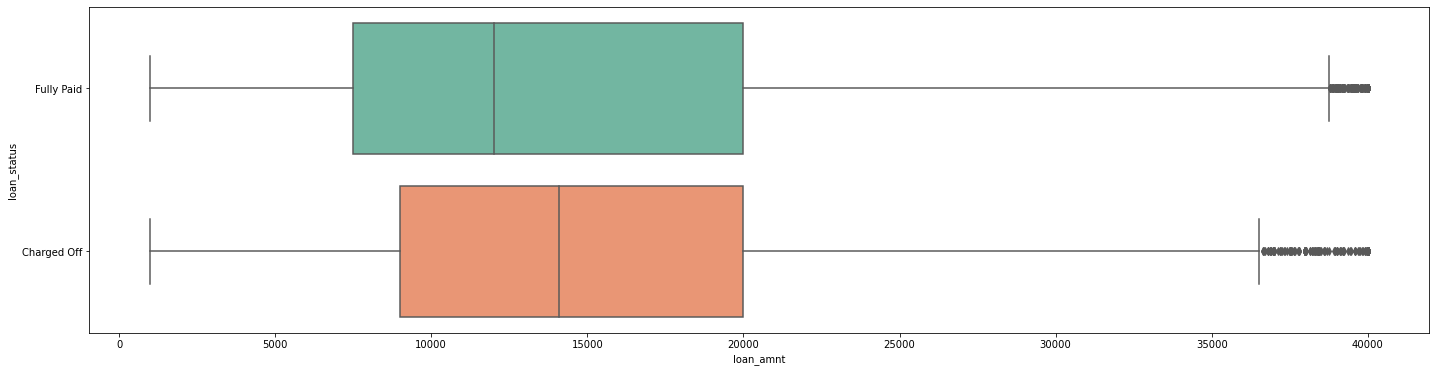

In [91]:
plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='loan_amnt', y='loan_status', palette='Set2');

### term

<AxesSubplot:xlabel='term', ylabel='count'>

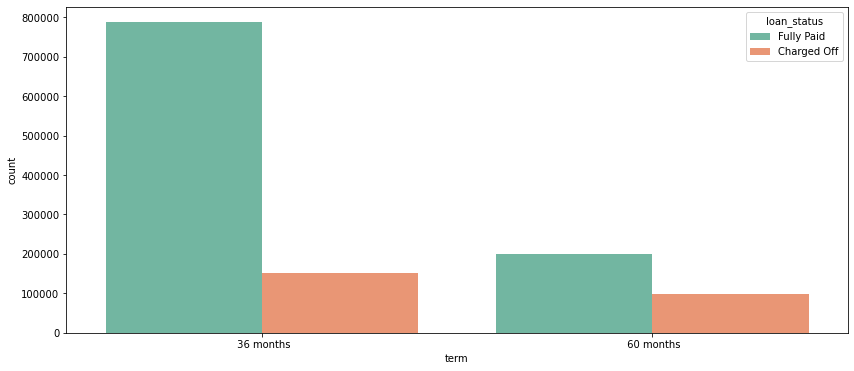

In [92]:
plt.figure(figsize=(14,6))
sns.countplot(x='term',data=loan,hue='loan_status', palette='Set2')

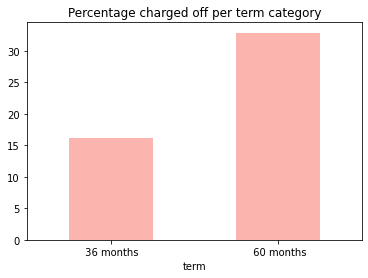

In [93]:
charged_off = loan[loan['loan_status']=="Charged Off"].groupby("term").count()['loan_status']
fully_paid = loan[loan['loan_status']=="Fully Paid"].groupby("term").count()['loan_status']
percent_charged_off = (charged_off * 100)/(charged_off + fully_paid)
percent_charged_off.plot(kind='bar', cmap='Pastel1')
plt.title("Percentage charged off per term category")
plt.xticks(rotation=0);

Loan term with 60 month has higher rate of charged off.

In [94]:
dummies_term = pd.get_dummies(loan['term'], prefix='term',drop_first=True)
loan= pd.concat([loan.drop('term', axis=1), dummies_term], axis=1)

### int_rate

In [95]:
loan.groupby('loan_status')['int_rate'].describe()

count       mean       std   min    25%    50%    75%    max
loan_status                                                                 
Charged Off  249420.0  15.766551  4.925374  5.31  12.35  15.05  18.55  30.99
Fully Paid   986579.0  12.655250  4.546824  5.31   9.17  12.29  15.31  30.99

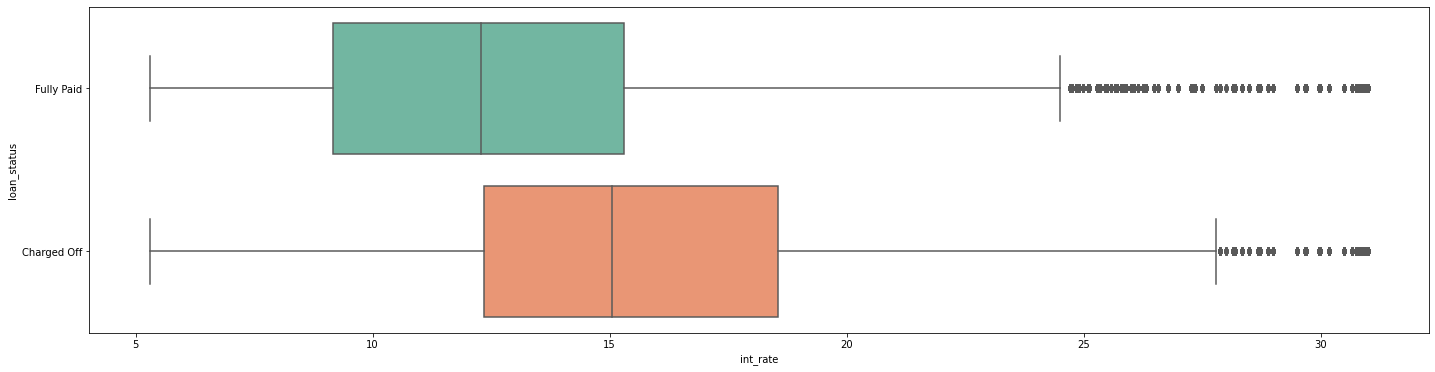

In [96]:
plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='int_rate', y='loan_status', palette='Set2');

### sub_grade 

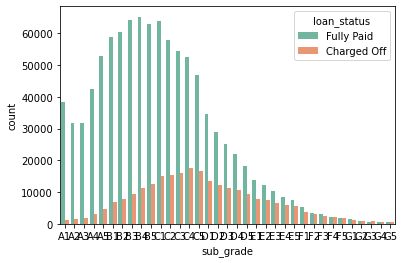

In [97]:
subgrade_order = sorted(loan['sub_grade'].unique().tolist())
sns.countplot(x='sub_grade',data=loan,order = subgrade_order, palette='Set2',hue='loan_status');


In [98]:
dummies_subgrade = pd.get_dummies(loan['sub_grade'], prefix='sub_grade',drop_first=True)
loan= pd.concat([loan.drop('sub_grade', axis=1), dummies_subgrade], axis=1)

### home_ownership

In [99]:
loan['home_ownership'].value_counts()

MORTGAGE    608692
RENT        492585
OWN         134353
ANY            280
NONE            45
OTHER           44
Name: home_ownership, dtype: int64

In [100]:
owndership_list=['MORTGAGE', 'RENT','OTHER','OWN']
loan= loan.loc[loan['home_ownership'].isin(owndership_list)]

In [101]:
loan.home_ownership.value_counts()

MORTGAGE    608692
RENT        492585
OWN         134353
OTHER           44
Name: home_ownership, dtype: int64

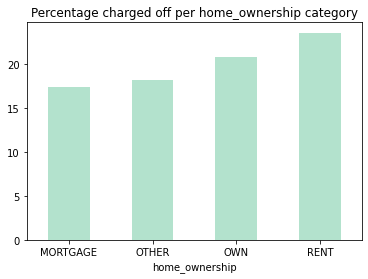

In [102]:
charged_off = loan[loan['loan_status']=="Charged Off"].groupby("home_ownership").count()['loan_status']
fully_paid = loan[loan['loan_status']=="Fully Paid"].groupby("home_ownership").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
percentage_charged_off.plot(kind='bar', cmap='Pastel2')
plt.title("Percentage charged off per home_ownership category")
plt.xticks(rotation=0);

In [103]:
#dummies_subgrade = pd.get_dummies(loan['sub_grade'], prefix='term',drop_first=True)
#loan= pd.concat([loan.drop('sub_grade', axis=1), dummies_subgrade], axis=1)

In [104]:
dummies_ownership = pd.get_dummies(loan['home_ownership'], prefix='home_ownership',drop_first=True)
loan= pd.concat([loan.drop('home_ownership', axis=1), dummies_ownership], axis=1)

### annual_inc

In [105]:
loan.groupby('loan_status')['annual_inc'].describe()

count          mean           std  min      25%      50%  \
loan_status                                                                
Charged Off  249360.0  69467.381485  65356.197968  0.0  43000.0  60000.0   
Fully Paid   986314.0  76264.557778  67181.191200  0.0  46900.0  65000.0   

                 75%         max  
loan_status                       
Charged Off  84000.0   9500000.0  
Fully Paid   91000.0  10999200.0

In [106]:
loan.shape

(1235674, 58)

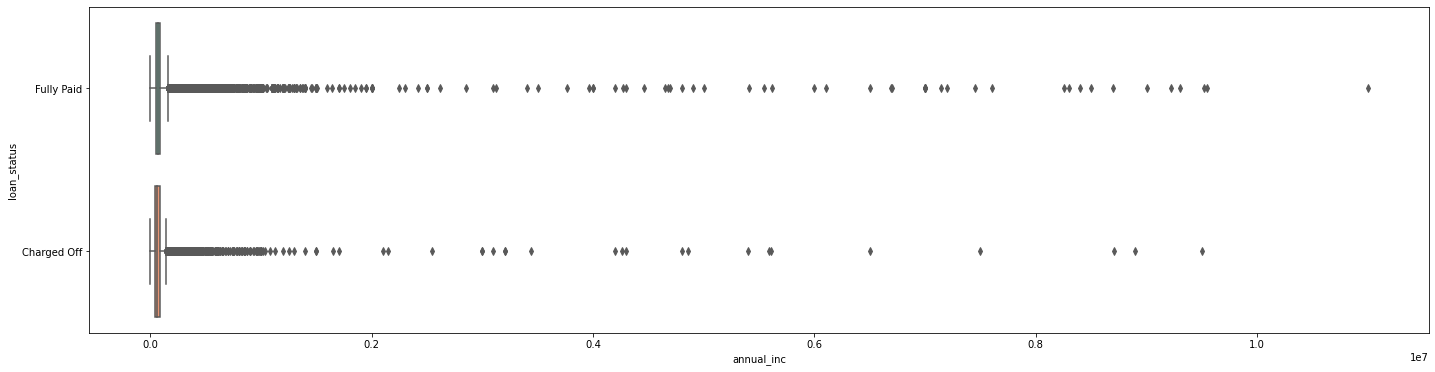

In [107]:
plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='annual_inc', y='loan_status', palette='Set2');

From above, outliers are observed. 

In [108]:
print(len(loan[loan['annual_inc']>250000])/loan.shape[0])

0.008131594579152754


Less than 1% customers have annual income greater than 250k.
Keep annual income less than 250k.

In [109]:
loan = loan[loan['annual_inc'] <= 250000]

### verification_status

In [110]:
loan.verification_status.value_counts()

Source Verified    482194
Verified           374769
Not Verified       368663
Name: verification_status, dtype: int64

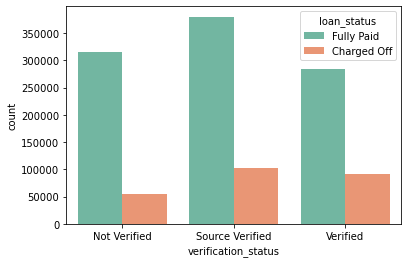

In [111]:
sns.countplot(data=loan, x='verification_status', hue='loan_status', palette='Set2');

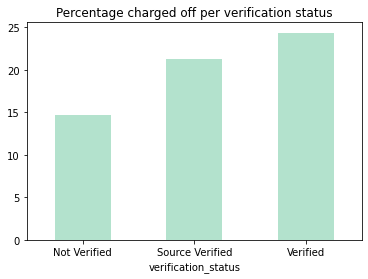

In [112]:
charged_off = loan[loan['loan_status']=="Charged Off"].groupby("verification_status").count()['loan_status']
fully_paid = loan[loan['loan_status']=="Fully Paid"].groupby("verification_status").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
percentage_charged_off.plot(kind='bar', cmap='Pastel2')
plt.title("Percentage charged off per verification status")
plt.xticks(rotation=0);

In [113]:
dummies_verification_status = pd.get_dummies(loan['verification_status'], drop_first=True)
loan= pd.concat([loan.drop('verification_status', axis=1), dummies_verification_status], axis=1)

### initial_list_status

In [114]:
loan.initial_list_status.value_counts()

w    750443
f    475183
Name: initial_list_status, dtype: int64

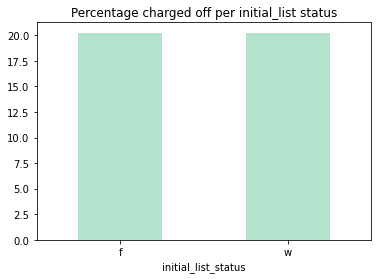

In [115]:
charged_off = loan[loan['loan_status']=="Charged Off"].groupby("initial_list_status").count()['loan_status']
fully_paid = loan[loan['loan_status']=="Fully Paid"].groupby("initial_list_status").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
percentage_charged_off.plot(kind='bar', cmap='Pastel2')
plt.title("Percentage charged off per initial_list status")
plt.xticks(rotation=0);

The percentage charged off in initial_list_status has no large difference. Drop this column.

In [116]:
loan=loan.drop('initial_list_status',axis=1)

### purpose

In [117]:
loan.purpose.value_counts()

debt_consolidation    718127
credit_card           271256
home_improvement       78179
other                  69809
major_purchase         25522
medical                14055
car                    12091
small_business         11923
moving                  8464
vacation                8244
house                   6325
wedding                  860
renewable_energy         770
educational                1
Name: purpose, dtype: int64

In [118]:
purpose_df= loan.purpose.value_counts()

In [119]:
purpose_df.head()

debt_consolidation    718127
credit_card           271256
home_improvement       78179
other                  69809
major_purchase         25522
Name: purpose, dtype: int64

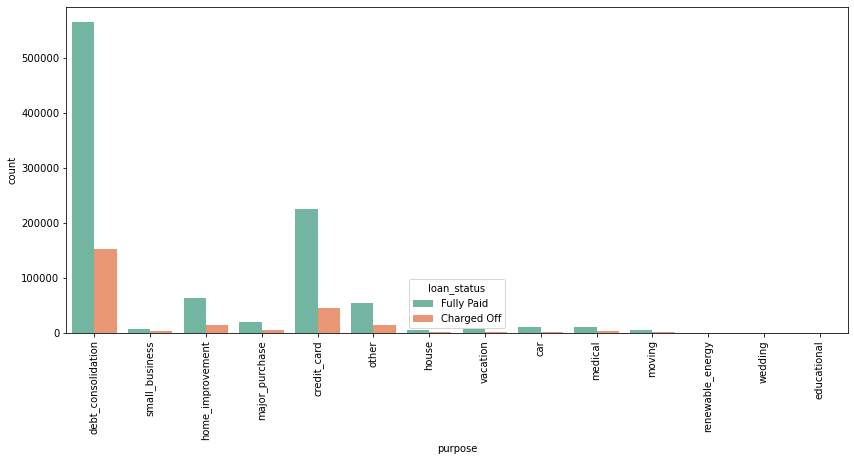

In [120]:
plt.figure(figsize=(14,6))
purpose_order = sorted(loan['purpose'].unique().tolist())
sns.countplot(x='purpose',data=loan,hue='loan_status', palette='Set2')
plt.xticks(rotation=90);

In [121]:
'''
clrs=['yellow' if (value < max(purpose_df.values)) else 'pink' for value in purpose_df.values]
ax=sns.countplot(data=loan,x='',y='price',palette=clrs,ci= None)
ax.set_xlabel('Purpose')
ax.set_ylabel('Counts')
ax.set_title('Price by Zip Code')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);
'''

"\nclrs=['yellow' if (value < max(purpose_df.values)) else 'pink' for value in purpose_df.values]\nax=sns.countplot(data=loan,x='',y='price',palette=clrs,ci= None)\nax.set_xlabel('Purpose')\nax.set_ylabel('Counts')\nax.set_title('Price by Zip Code')\nax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))\nax.set_xticklabels(ax.get_xticklabels(),rotation=90);\n"

In [122]:
dummies_purpose = pd.get_dummies(loan['purpose'], prefix='purpose',drop_first=True)
loan= pd.concat([loan.drop('purpose', axis=1), dummies_purpose], axis=1)

### addr_state 

In [123]:
loan.addr_state.value_counts()

CA    175798
TX    101375
NY     97960
FL     86886
IL     46720
NJ     42617
PA     41346
OH     40604
GA     39484
NC     34871
VA     34158
MI     32813
AZ     29954
MD     28137
MA     27428
CO     27252
WA     26725
MN     22168
IN     21124
TN     19741
MO     19530
NV     18737
CT     17326
WI     16432
AL     15462
OR     15181
SC     14758
LA     14267
KY     11915
OK     11459
KS     10435
AR      9278
UT      9235
NM      6842
MS      6383
HI      6235
NH      5889
RI      5313
WV      4476
MT      3559
NE      3489
DE      3443
DC      2986
AK      2933
WY      2705
SD      2571
VT      2469
ME      1955
ID      1641
ND      1559
IA         2
Name: addr_state, dtype: int64

In [124]:
dummies_state = pd.get_dummies(loan['addr_state'], drop_first=True)
loan= pd.concat([loan.drop('addr_state', axis=1), dummies_state], axis=1)

### application type

In [125]:
loan.application_type.value_counts()

Individual    1200478
Joint App       25148
Name: application_type, dtype: int64

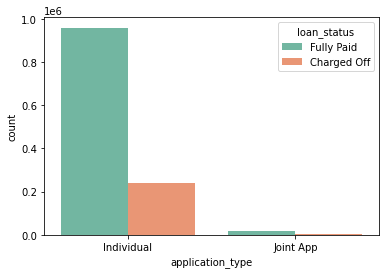

In [126]:
sns.countplot(data=loan, x='application_type', hue='loan_status', palette='Set2');

In [127]:
dummies_apptype = pd.get_dummies(loan['application_type'], drop_first=True)
loan= pd.concat([loan.drop('application_type', axis=1), dummies_apptype], axis=1)

### fico_range_low & fico_range_high 

In [128]:
loan.groupby('loan_status')['fico_range_high'].describe()

count        mean        std    min    25%    50%    75%  \
loan_status                                                                
Charged Off  247991.0  691.361352  25.649179  664.0  674.0  684.0  704.0   
Fully Paid   977635.0  701.301943  32.465157  664.0  674.0  694.0  719.0   

               max  
loan_status         
Charged Off  850.0  
Fully Paid   850.0

In [129]:
loan.groupby('loan_status')['fico_range_low'].describe()

count        mean        std    min    25%    50%    75%  \
loan_status                                                                
Charged Off  247991.0  687.361295  25.648830  660.0  670.0  680.0  700.0   
Fully Paid   977635.0  697.301779  32.464409  660.0  670.0  690.0  715.0   

               max  
loan_status         
Charged Off  845.0  
Fully Paid   845.0

There is no significant difference between fico_range_high and fico_range_low.

Keep fico_range_high in the dataset

In [130]:
loan = loan.drop('fico_range_low',axis=1)

In [131]:
# Convert columns with yes or no to binary
label_encoder = LabelEncoder()
loan['loan_status'] = label_encoder.fit_transform(loan['loan_status'])

In [132]:
loan.head()

loan_amnt  int_rate  annual_inc  loan_status  fico_range_high  open_acc  \
0     3600.0     13.99     55000.0            1            679.0       7.0   
1    24700.0     11.99     65000.0            1            719.0      22.0   
2    20000.0     10.78     63000.0            1            699.0       6.0   
4    10400.0     22.45    104433.0            1            699.0      12.0   
5    11950.0     13.44     34000.0            1            694.0       5.0   

   pub_rec  revol_bal  revol_util  total_acc  ...  TN  TX  UT  VA  VT  WA  WI  \
0        0     2765.0        29.7       13.0  ...   0   0   0   0   0   0   0   
1        0    21470.0        19.2       38.0  ...   0   0   0   0   0   0   0   
2        0     7869.0        56.2       18.0  ...   0   0   0   0   0   0   0   
4        0    21929.0        64.5       35.0  ...   0   0   0   0   0   0   0   
5        0     8822.0        68.4        6.0  ...   0   0   0   0   0   0   0   

   WV  WY  Joint App  
0   0   0          0  
1   0   0          0  
2   0   0          1  
4   0   0          0  
5   0   0          0  

[5 rows x 118 columns]

In [133]:
loan.dtypes.index

Index(['loan_amnt', 'int_rate', 'annual_inc', 'loan_status', 'fico_range_high',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       ...
       'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'Joint App'],
      dtype='object', length=118)

## Define X and Y

In [136]:
X = loan.drop(['loan_status'],axis=1)
y = loan['loan_status']

## Train Test Split 

Split the data into train and test set by test size 25%

In [137]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state = 123)

## Standardize the Data

Standardize the data since the features in the data set have different ranges.

In [138]:
#Instantiate StandardScaler
scaler = StandardScaler()

#Transform X_train to scaled data set and fit the model with scaled X train data
scaled_X_train = scaler.fit_transform(X_train)

#Transform X_test to scaled data set
scaled_X_test= scaler.transform(X_test)

#Convert scaled data into a DataFrame
scaled_X_train = pd.DataFrame(scaled_X_train,columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaled_X_test,columns=X_test.columns)

## Logistic Regression Model

test:
              precision    recall  f1-score   support

           0       0.54      0.06      0.11     61681
           1       0.81      0.99      0.89    244726

    accuracy                           0.80    306407
   macro avg       0.68      0.52      0.50    306407
weighted avg       0.75      0.80      0.73    306407

train:
              precision    recall  f1-score   support

           0       0.54      0.06      0.11    186310
           1       0.81      0.99      0.89    732909

    accuracy                           0.80    919219
   macro avg       0.68      0.52      0.50    919219
weighted avg       0.75      0.80      0.73    919219

Test Recall_score 0.9866340315291388
Test accuracy score 0.8007421501467002


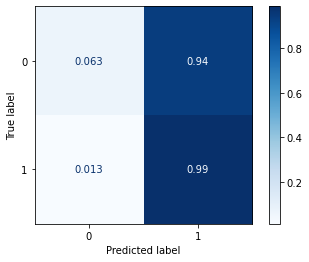

In [139]:
lr= LogisticRegression(random_state = 123)
lr.fit(scaled_X_train,y_train)

y_train_pred = lr.predict(scaled_X_train)
y_test_pred = lr.predict(scaled_X_test)


plot_confusion_matrix(lr,scaled_X_test,y_test,
                                normalize='true',
                                cmap='Blues')


rs = recall_score(y_train,y_train_pred)
print(f"test:\n{classification_report(y_test,y_test_pred)}")
print(f"train:\n{classification_report(y_train,y_train_pred)}")

#print Test recall score
rs = recall_score(y_test,y_test_pred)
print(f"Test Recall_score {rs}")

# Print the accuracy on test set

print(f"Test accuracy score {lr.score(scaled_X_test,y_test)}")

Create a function to print scores and confusion matrix for the models

In [140]:
def eval_model(model,X_train,y_train,X_test,y_test):
    
    #fit the model
    model.fit(X_train,y_train)
    
    #predict the target variable
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    #plot the confusion matrix with test set
    plot_confusion_matrix(model,X_test,y_test,normalize='true',cmap='Blues')
    
    #print recall score and classification report for train set and test set
    rs_train = recall_score(y_train,y_train_pred)
    rs_test = recall_score(y_test, y_test_pred)
    print(f"test:\n{classification_report(y_test,y_test_pred)}")
    print(f"train:\n{classification_report(y_train,y_train_pred)}")
    print(f"Train Recall_score {rs_train}")
    print(f"Test Recall_score {rs_test}")

    # Print the accuracy of a model
    acc_score = model.score(X_test,y_test)
    acc_score_train = model.score(X_train,y_train)
    print(f"Train accuracy score {acc_score_train}")
    print(f"Test accuracy score {acc_score}")

## Decision Tree Model

In [141]:
# Instantiate a DecisionTreeClassifier()
dt= DecisionTreeClassifier(max_depth=3,random_state=123)

test:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     61681
           1       0.80      1.00      0.89    244726

    accuracy                           0.80    306407
   macro avg       0.40      0.50      0.44    306407
weighted avg       0.64      0.80      0.71    306407

train:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    186310
           1       0.80      1.00      0.89    732909

    accuracy                           0.80    919219
   macro avg       0.40      0.50      0.44    919219
weighted avg       0.64      0.80      0.71    919219

Train Recall_score 1.0
Test Recall_score 1.0
Train accuracy score 0.7973170702520291
Test accuracy score 0.7986958522488063


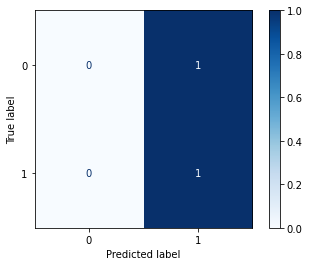

In [142]:
eval_model(dt,scaled_X_train,y_train,scaled_X_test,y_test)

## Random Forest Model

In [143]:
rf = RandomForestClassifier(random_state =123)

test:
              precision    recall  f1-score   support

           0       0.53      0.08      0.14     61681
           1       0.81      0.98      0.89    244726

    accuracy                           0.80    306407
   macro avg       0.67      0.53      0.51    306407
weighted avg       0.75      0.80      0.74    306407

train:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    186310
           1       1.00      1.00      1.00    732909

    accuracy                           1.00    919219
   macro avg       1.00      1.00      1.00    919219
weighted avg       1.00      1.00      1.00    919219

Train Recall_score 1.0
Test Recall_score 0.9820452260895859
Train accuracy score 0.9999891211996271
Test accuracy score 0.8003309323873149


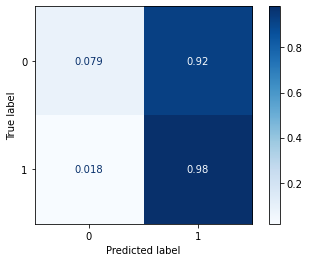

In [144]:
eval_model(rf,scaled_X_train,y_train,scaled_X_test,y_test)

## XG Boost Model

In [145]:
xg = XGBClassifier(random_state =123)

[01:09:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
test:
              precision    recall  f1-score   support

           0       0.56      0.09      0.16     61681
           1       0.81      0.98      0.89    244726

    accuracy                           0.80    306407
   macro avg       0.68      0.54      0.52    306407
weighted avg       0.76      0.80      0.74    306407

train:
              precision    recall  f1-score   support

           0       0.62      0.10      0.18    186310
           1       0.81      0.98      0.89    732909

    accuracy                           0.81    919219
   macro avg       0.71      0.54      0.53    919219
weighted avg       0.77      0.81      0.74    919219

Train Recall_score 0.9837196705184409
Test Recall_score 0.9815548817861609
Train 

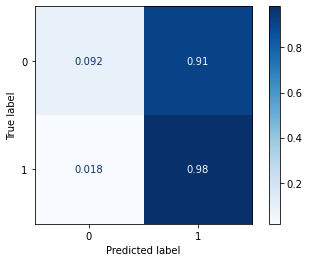

In [146]:
eval_model(xg,scaled_X_train,y_train,scaled_X_test,y_test)

## Tuning XG Boost Model

In [147]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [1,2,5,10],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

In [148]:
grid_clf = GridSearchCV(xg,param_grid,cv=3,scoring='recall',n_jobs=1)
grid_clf.fit(scaled_X_train,y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(scaled_X_train)
test_preds = grid_clf.predict(scaled_X_test)
training_accuracy = accuracy_score(y_train,training_preds)
test_accuracy = accuracy_score(y_test,test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

[01:12:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:12:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:13:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:13:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[01:28:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:29:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:30:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:31:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:00:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:00:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:01:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:01:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [153]:
xg_grid_smote=XGBClassifier(learning_rate=0.1,max_depth=1, min_child_weight=1,n_estimators=100, subsample=0.5)

[19:17:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
test:
              precision    recall  f1-score   support

           0       0.60      0.01      0.01     61681
           1       0.80      1.00      0.89    244726

    accuracy                           0.80    306407
   macro avg       0.70      0.50      0.45    306407
weighted avg       0.76      0.80      0.71    306407

train:
              precision    recall  f1-score   support

           0       0.60      0.01      0.01    186310
           1       0.80      1.00      0.89    732909

    accuracy                           0.80    919219
   macro avg       0.70      0.50      0.45    919219
weighted avg       0.76      0.80      0.71    919219

Train Recall_score 0.9990257999287769
Test Recall_score 0.9989907079754501
Train 

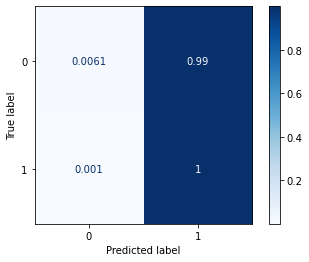

In [154]:
eval_model(xg_grid_smote,scaled_X_train,y_train,scaled_X_test,y_test)

## Find Feature Importances in XGBoost Model

Calculating feature importances and plot the feature by sorted values

In [155]:
# Calculate feature importances
feature_importances = xg_grid_smote.feature_importances_

# Create a list of features: done
feature_list = list(scaled_X_train.columns)

# Save the results inside a DataFrame using feature_list as an index
relative_importances = pd.DataFrame(index=feature_list, data=feature_importances, columns=["importance"])

# Sort values to learn most important features
relative_importances.sort_values(by="importance", ascending=False)


# Show top 10 features
result = relative_importances.reset_index().sort_values('importance',ascending=False).iloc[:10]



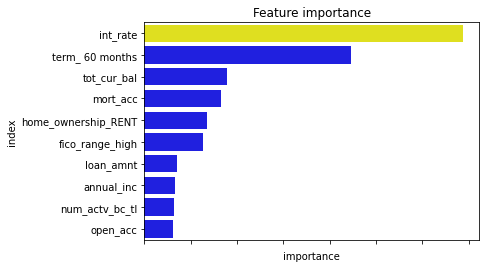

In [156]:
# plot feature imporances with sorted values
clrs=['blue' if (value < max(result.importance)) else 'yellow' for value in result.importance]
ax=sns.barplot(data=result,x='importance',y='index',palette=clrs,ci= None)
ax.set_xlabel('importance')
ax.set_ylabel('index')
ax.set_title('Feature importance')

ax.set_xticklabels(ax.get_xticklabels(),rotation=90);